Конфигурационная модель (https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.directed_configuration_model.html)

Генерируем рапсределние степеней (in/out):
* in/out - Poisson
* in/out - Степенное

Определить количество петель, мультиребер, двунаправленных связей

In [5]:
#pip install ndlib

In [7]:
#pip install matplotlib

In [14]:
#pip install seaborn

In [1]:
import networkx as nx
import numpy as np

In [2]:
import ndlib.models.epidemics as sir
import ndlib.models.ModelConfig as mc
import matplotlib.pyplot as plt

In [3]:
def edges_type(degree_type, graph):
    edges = graph.edges()
    print (f"Edges in graph with {degree_type} degree distribution: ", len(edges))

    bidirected = 0
    self_loops = 0
    multiedges = 0

    for edge in edges:
        if edge[0] == edge[1]:
            self_loops += 1 
        if (edge[1], edge[0]) in edges:
            bidirected += 1

    edges_dict = {}
    for edge in edges:
        if edge in edges_dict:
            edges_dict[edge] += 1
        else:
            edges_dict[edge] = 1
        
    for val in edges_dict.values():
        if val > 1:
            multiedges += 1        
        
    print("Bidirected edges: ", bidirected, "(%f)" % float(bidirected / len(edges)))
    print("Self-loops in graph: ", self_loops, '(%f)' % float(self_loops / len(edges)))
    print("Multi-edges in graph: ", multiedges, "(%f)" % float(multiedges / len(edges)))        

In [4]:
def SIR(degree_type,graph, N, beta, gamma):
    sir_model = sir.SIRModel(graph)

    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma',gamma)
    config.add_model_parameter("percentage_infected", 0.01)
    sir_model.set_initial_status(config)
    
    iterations = sir_model.iteration_bunch(1000)
    susceptible,infected,recovered = [],[],[]
 
    for iteration in iterations:
        node_count = iteration['node_count']
        susceptible.append(node_count[0]/N)
        infected.append(node_count[1]/N)
        recovered.append(node_count[2]/N)

    plt.figure(figsize = (6,4))
    plt.title('SIR')
    plt.plot(infected,color='r',label='infected')
    plt.plot(susceptible, color='b',label='susceptible')
    plt.plot(recovered, color='k',label='recovered')
    plt.xlabel('time', fontsize = 14)
    plt.ylabel('node/N', fontsize = 14)
    plt.legend()
    plt.savefig(f'{degree_type}.png')

In [5]:
def recovered_infected(degree_type, in_degree, out_degree, N, beta, gamma):
    
    full_res_infected, full_res_recovered = [],[]
    
    for i in range(100):
        graph = nx.directed_configuration_model(in_degree, out_degree)
        sir_model = sir.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)#0.007)
        config.add_model_parameter('gamma',gamma)#0.02)
        config.add_model_parameter("percentage_infected", 0.01)
        sir_model.set_initial_status(config)
        iterations = sir_model.iteration_bunch(800)
    
        infected,recovered = [],[]
        for iteration in iterations:
            node_count = iteration['node_count']
            infected.append(node_count[1]/N)
            recovered.append(node_count[2]/N)
        
        full_res_infected.append(infected)
        full_res_recovered.append(recovered)
        
    mean_infected = np.mean(full_res_infected, axis = 0)
    mean_recovered = np.mean(full_res_recovered, axis = 0)
    
    assert len(mean_infected) == len(full_res_infected[0]), 'Vector lengths are not equal'
    
    std_infected = np.std(full_res_infected, axis = 0)
    std_recovered = np.std(full_res_recovered, axis = 0)
    
    assert len(std_infected) == len(full_res_infected[0]), 'Vector lengths are not equal'
    
    return mean_infected, mean_recovered, std_infected, std_recovered

## In - poisson, out - poisson

Edges in graph with poisson degree distribution:  12118
Bidirected edges:  168 (0.013864)
Self-loops in graph:  10 (0.000825)
Multi-edges in graph:  82 (0.006767)


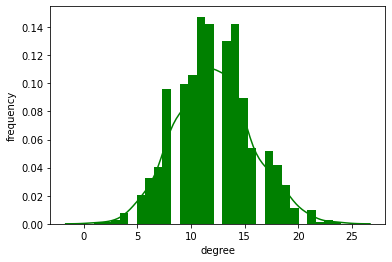

In [9]:
from scipy.stats import poisson
import seaborn as sb

data_binom = poisson.rvs(mu=11.95, size=1000)

dif_degree = sum(data_powerlaw) - sum(data_binom) #150
data_binom_final = np.concatenate([data_binom[:dif_degree]+1, data_binom[dif_degree:]])
N = len(data_binom_final) #edges number 

ax = sb.distplot(data_binom_final,
                  color='green',
                  hist_kws={"linewidth": 25,'alpha':1})
ax.set(xlabel = 'degree', ylabel = 'frequency')
plot = ax.get_figure()
plot.savefig("poisson_distribution.png")

in_degree, out_degree = data_binom_final, data_binom_final
graph_poisson = nx.directed_configuration_model(in_degree, out_degree, seed=42)
edges_type('poisson', graph_poisson)

In [10]:
SIR('poisson_poisson',graph_poisson, N)

TypeError: SIR() missing 2 required positional arguments: 'beta' and 'gamma'

In [7]:
#генератор степенного распределения
def power_law(x_min,gamma):
    r=np.random.random()
    return round(x_min*np.float_power((r),1/(-gamma+1))) # обратная к F_cd функция

## In - powerlaw, out - powerlaw

Edges in graph with powerlaw degree distribution:  12118
Bidirected edges:  462 (0.038125)
Self-loops in graph:  21 (0.001733)
Multi-edges in graph:  191 (0.015762)


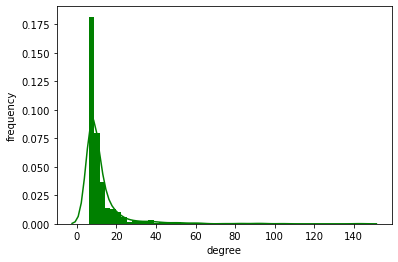

In [8]:
import seaborn as sb

np.random.seed(10)
data_powerlaw = []
x_min, gamma = 6, 3

for i in range(1000):
    data_powerlaw.append(power_law(x_min,gamma))

ax = sb.distplot(data_powerlaw,
                  color='green',
                  hist_kws={"linewidth": 25,'alpha':1})
ax.set(xlabel = 'degree', ylabel = 'frequency')
plot = ax.get_figure()
plot.savefig("powerlaw_distribution.png")

in_degree, out_degree = data_powerlaw, data_powerlaw
#out_degree = new_arr
graph_powerlaw = nx.directed_configuration_model(in_degree, out_degree)
edges_type('powerlaw', graph_powerlaw)

100%|██████████| 1000/1000 [00:04<00:00, 239.04it/s]


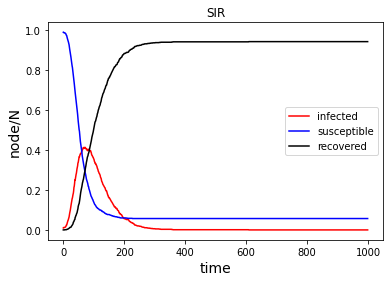

In [11]:
SIR('powerlaw_powerlaw',graph_powerlaw, len(data_powerlaw))

Параметры степенного powerlaw распределения подобраны так, чтобы число ребер и средняя степень вершин совпадали

В графе со степенным распределением in/out степеней доли двунаправленных мультиребер в графах близки

## In - poisson, out - powerlaw

In [14]:
in_degree, out_degree = data_binom_final, data_powerlaw
graph_poisson_powerlaw = nx.directed_configuration_model(in_degree, out_degree)
edges_type('poisson_powerlaw', graph_poisson_powerlaw)

Edges in graph with poisson_powerlaw degree distribution:  12118
Bidirected edges:  153 (0.012626)
Self-loops in graph:  18 (0.001485)
Multi-edges in graph:  126 (0.010398)


100%|██████████| 1000/1000 [00:04<00:00, 211.88it/s]


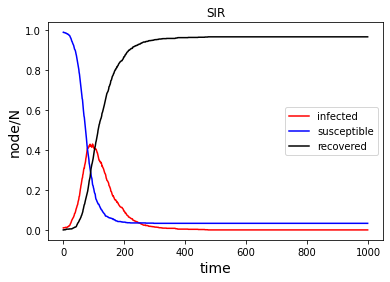

In [15]:
SIR('poisson_powerlaw', graph_poisson_powerlaw, len(data_powerlaw))

## In - powerlaw, out - poisson

In [11]:
in_degree, out_degree = data_powerlaw, data_binom_final
graph_powerlaw_poisson = nx.directed_configuration_model(in_degree, out_degree)
edges_type('powerlaw_poisson', graph_powerlaw_poisson)

Edges in graph with powerlaw_poisson degree distribution:  12118
Bidirected edges:  145 (0.011966)
Self-loops in graph:  11 (0.000908)
Multi-edges in graph:  111 (0.009160)


100%|██████████| 1000/1000 [00:05<00:00, 191.13it/s]


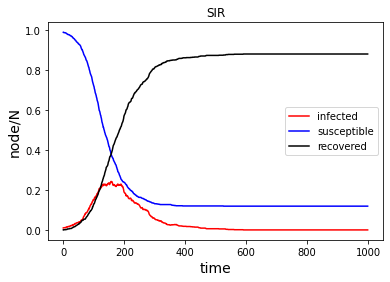

In [17]:
SIR('powerlaw_poisson', graph_powerlaw_poisson, len(data_powerlaw))

Построим на одном графике 4 функции доли зараженных (от времени) для анализа пиков и времени заражения. Эти показатели помогут охарактеризовать как влияет распределение степеней на скорость и силу распространения.

Фикс граф , на каждом графе 100 раз запускаю Sir (при этом изначально активированы будут разные вершины) -> средний график + std

In [46]:
mean_infect_pois_pois, mean_rec_pois_pois, std_infect_pois_pois, std_rec_pois_pois = recovered_infected('poisson_poisson', 
                                                                data_binom_final, data_binom_final, N = 1000, beta = 0.007, gamma=0.02)

mean_infect_pow_pow, mean_rec_pow_pow, std_infect_pow_pow, std_rec_pow_pow = recovered_infected('powerlaw_powerlaw', 
                                                                data_powerlaw, data_powerlaw, N = 1000, beta = 0.007, gamma=0.02)

mean_infect_pow_pois, mean_rec_pow_pois, std_infect_pow_pois, std_rec_pow_pois = recovered_infected('powerlaw_poisson', 
                                                                data_powerlaw, data_binom_final, N = 1000, beta = 0.007, gamma=0.02)

mean_infect_pois_pow, mean_rec_pois_pow, std_infect_pois_pow, std_rec_pois_pow = recovered_infected('poisson_powerlaw', 
                                                                data_binom_final, data_powerlaw, N = 1000, beta = 0.007, gamma=0.02)

100%|██████████| 800/800 [00:03<00:00, 228.18it/s]


100%|██████████| 800/800 [00:03<00:00, 232.80it/s]


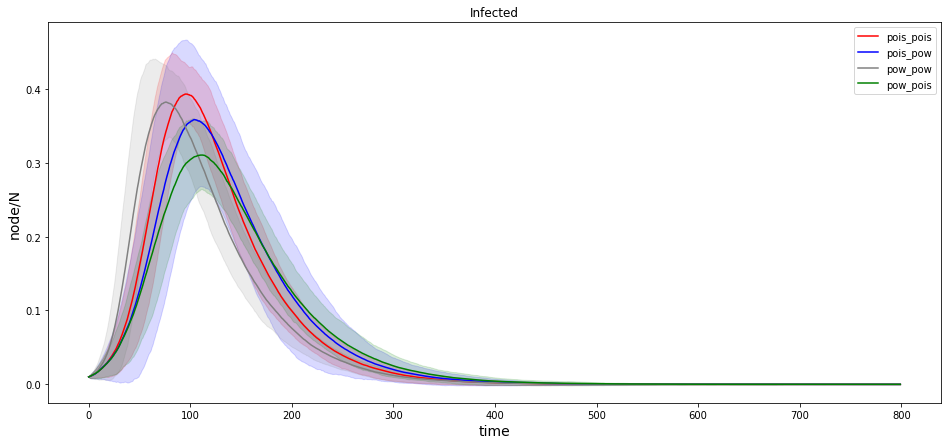

In [47]:
low_border_infect_pois_pois = mean_infect_pois_pois - 2*std_infect_pois_pois 
high_border_infect_pois_pois = mean_infect_pois_pois + 2*std_infect_pois_pois

low_border_infect_pow_pow = mean_infect_pow_pow - 2*std_infect_pow_pow 
high_border_infect_pow_pow = mean_infect_pow_pow + 2*std_infect_pow_pow

low_border_infect_pois_pow = mean_infect_pois_pow - 2*std_infect_pois_pow 
high_border_infect_pois_pow = mean_infect_pois_pow + 2*std_infect_pois_pow

low_border_infect_pow_pois = mean_infect_pow_pois - 2*std_infect_pow_pois 
high_border_infect_pow_pois = mean_infect_pow_pois + 2*std_infect_pow_pois



plt.figure(figsize = (16,7))
plt.title('Infected')
plt.plot(mean_infect_pois_pois, color = 'red', label = 'pois_pois')
plt.fill_between(range(800), low_border_infect_pois_pois, high_border_infect_pois_pois, 
                 color = 'red', alpha=0.15)

plt.plot(mean_infect_pois_pow, color = 'blue', label = 'pois_pow')
plt.fill_between(range(800), low_border_infect_pois_pow, high_border_infect_pois_pow, 
                 color = 'blue', alpha=0.15)

plt.plot(mean_infect_pow_pow, color = 'grey', label = 'pow_pow')
plt.fill_between(range(800), low_border_infect_pow_pow, high_border_infect_pow_pow, 
                 color = 'grey', alpha=0.15)

plt.plot(mean_infect_pow_pois, color= 'green', label = 'pow_pois')
plt.fill_between(range(800), low_border_infect_pow_pois, high_border_infect_pow_pois, 
                 color = 'green', alpha=0.15)

plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()
plt.savefig('infected.png')

Самое медленное распространение заражения в графе, где in_degree - степенное, out_degree - Пуассоновское. Предсказуемо, так как образуются вершины, в которые много ребер входит и не так много исходит.

Для картинки оптимальные параметры beta = 0.007, gamma = 0.02, при других параметрах картинка яснее не становится

In [56]:
plt.savefig('infected.png')

<Figure size 432x288 with 0 Axes>

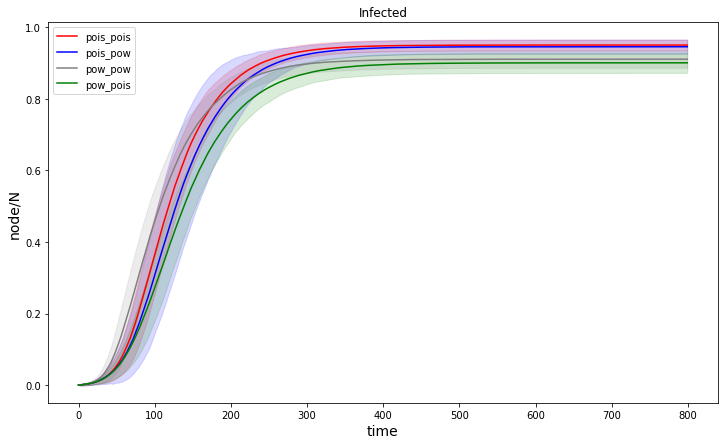

In [48]:
low_border_rec_pois_pois = mean_rec_pois_pois - 2*std_rec_pois_pois 
high_border_rec_pois_pois = mean_rec_pois_pois + 2*std_rec_pois_pois

low_border_rec_pow_pow = mean_rec_pow_pow - 2*std_rec_pow_pow 
high_border_rec_pow_pow = mean_rec_pow_pow + 2*std_rec_pow_pow

low_border_rec_pois_pow = mean_rec_pois_pow - 2*std_rec_pois_pow 
high_border_rec_pois_pow = mean_rec_pois_pow + 2*std_rec_pois_pow

low_border_rec_pow_pois = mean_rec_pow_pois - 2*std_rec_pow_pois 
high_border_rec_pow_pois = mean_rec_pow_pois + 2*std_rec_pow_pois


plt.figure(figsize = (12,7))
plt.title('Recovered')
plt.plot(mean_rec_pois_pois, color = 'red', label = 'pois_pois')
plt.fill_between(range(800), low_border_rec_pois_pois, high_border_rec_pois_pois, 
                 color = 'red', alpha=0.15)

plt.plot(mean_rec_pois_pow, color = 'blue', label = 'pois_pow')
plt.fill_between(range(800), low_border_rec_pois_pow, high_border_rec_pois_pow, 
                 color = 'blue', alpha=0.15)

plt.plot(mean_rec_pow_pow, color = 'grey', label = 'pow_pow')
plt.fill_between(range(800), low_border_rec_pow_pow, high_border_rec_pow_pow, 
                 color = 'grey', alpha=0.15)

plt.plot(mean_rec_pow_pois, color= 'green', label = 'pow_pois')
plt.fill_between(range(800), low_border_rec_pow_pois, high_border_rec_pow_pois, 
                 color = 'green', alpha=0.15)

plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()
plt.savefig('recovered.png')

In [37]:
full_res_infected, full_res_recovered = [],[]
    
for i in range(100):
        graph = nx.directed_configuration_model(data_powerlaw, data_binom_final)
        graph = graph.reverse()
        sir_model = sir.SIRModel(graph)
        config = mc.Configuration()
        config.add_model_parameter('beta', 0.008)
        config.add_model_parameter('gamma', 0.02)
        config.add_model_parameter("percentage_infected", 0.01)
        sir_model.set_initial_status(config)
        iterations = sir_model.iteration_bunch(700)
    
        infected,recovered = [],[]
        for iteration in iterations:
            node_count = iteration['node_count']
            infected.append(node_count[1]/N)
            #recovered.append(node_count[2]/N)
        
        full_res_infected.append(infected)
        full_res_recovered.append(recovered)
        
mean_infected = np.mean(full_res_infected, axis = 0)
#mean_recovered = np.mean(full_res_recovered, axis = 0)
    
assert len(mean_infected) == len(full_res_infected[0]), 'Vector lengths are not equal'
    
std_infected = np.std(full_res_infected, axis = 0)
#std_recovered = np.std(full_res_recovered, axis = 0)
    
assert len(std_infected) == len(full_res_infected[0]), 'Vector lengths are not equal'

100%|██████████| 700/700 [00:03<00:00, 212.75it/s]


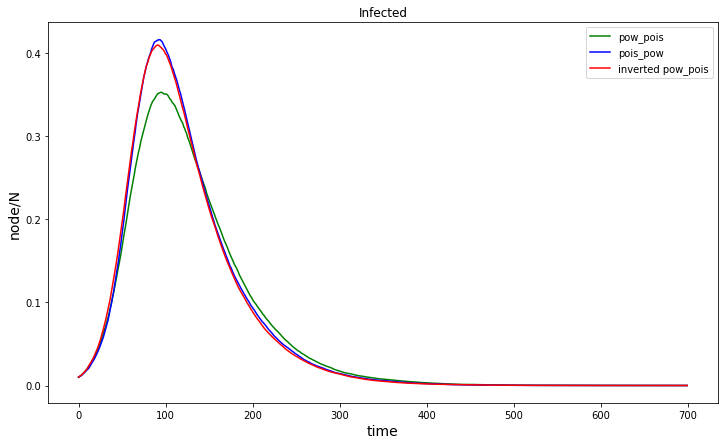

In [44]:
plt.figure(figsize = (12,7))
plt.title('Infected')

plt.plot(mean_infect_pow_pois, color= 'green', label = 'pow_pois')

plt.plot(mean_infect_pois_pow, color = 'blue', label = 'pois_pow')

plt.plot(mean_infected, color = 'red', label = 'inverted pow_pois')

plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()

Графики числа зараженных в инвертированном графе pow_pois (in_degree = powerlaw, out_degree = poisson) и графе pois_pow (in_degree = poisson, out_degree = powerlaw) практически идентичные